In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras import Model, Input, regularizers, utils
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing import image

import glob
from tqdm import tqdm
import os
import random
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
from torch.nn import functional as F
import torch
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras

C:\Users\soura\anaconda3\envs\machine-learning\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
root = 'D:/Encoders/dataset/testA/'
face_images = glob.glob(root + "*.*")

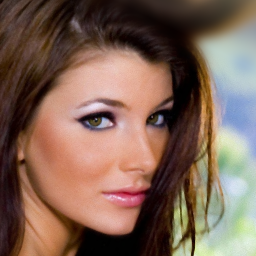

In [3]:
img = utils.load_img(face_images[0])
img

In [4]:
all_images = []

for i in tqdm(face_images[:100]):
    img = utils.load_img(i)
    img = utils.img_to_array(img)
    img = img/255.0
    all_images.append(img)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 52.82it/s]


In [5]:
all_images = np.array(all_images)

# split data into train and validation data
train_x, test_x = train_test_split(all_images, random_state=32, test_size=0.1)

In [31]:
def _get_norm_layer(norm):
    if norm == 'none':
        return lambda: lambda x: x
    elif norm == 'batch_norm':
        return keras.layers.BatchNormalization
    elif norm == 'instance_norm':
        return tfa.layers.InstanceNormalization
    elif norm == 'layer_norm':
        return keras.layers.LayerNormalization

In [32]:
def ResnetGenerator(input_shape=(256, 256, 3),
                    output_channels=3,
                    dim=64,
                    n_downsamplings=2,
                    n_blocks=9,
                    norm='instance_norm'):
    Norm = _get_norm_layer(norm)

    def _residual_block(x):
        dim = x.shape[-1]
        h = x

        h = tf.pad(h, [[0, 0], [1, 1], [1, 1], [0, 0]], mode='REFLECT')
        h = keras.layers.Conv2D(dim, 3, padding='valid', use_bias=False)(h)
        h = Norm()(h)
        h = tf.nn.relu(h)

        h = tf.pad(h, [[0, 0], [1, 1], [1, 1], [0, 0]], mode='REFLECT')
        h = keras.layers.Conv2D(dim, 3, padding='valid', use_bias=False)(h)
        h = Norm()(h)

        return keras.layers.add([x, h])

    # 0
    h = inputs = keras.Input(shape=input_shape)

    # 1
    h = tf.pad(h, [[0, 0], [3, 3], [3, 3], [0, 0]], mode='REFLECT')
    h = keras.layers.Conv2D(dim, 7, padding='valid', use_bias=False)(h)
    h = Norm()(h)
    h = tf.nn.relu(h)

    # 2
    for _ in range(n_downsamplings):
        dim *= 2
        h = keras.layers.Conv2D(dim, 3, strides=2, padding='same', use_bias=False)(h)
        h = Norm()(h)
        h = tf.nn.relu(h)

    # 3
    for _ in range(n_blocks):
        h = _residual_block(h)

    # 4
    for _ in range(n_downsamplings):
        dim //= 2
        h = keras.layers.Conv2DTranspose(dim, 3, strides=2, padding='same', use_bias=False)(h)
        h = Norm()(h)
        h = tf.nn.relu(h)

    # 5
    h = tf.pad(h, [[0, 0], [3, 3], [3, 3], [0, 0]], mode='REFLECT')
    h = keras.layers.Conv2D(output_channels, 7, padding='valid')(h)
    h = tf.tanh(h)

    return keras.Model(inputs=inputs, outputs=h)

In [33]:
model = ResnetGenerator()

In [34]:
model.compile(optimizer='adam', loss='mse')

In [35]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.compat.v1.pad_40 (TFOpLambd  (None, 262, 262, 3)  0          ['input_3[0][0]']                
 a)                                                                                               
                                                                                                  
 conv2d_44 (Conv2D)             (None, 256, 256, 64  9408        ['tf.compat.v1.pad_40[0][0]']    
                                )                                                           

                                                                                                  
 conv2d_51 (Conv2D)             (None, 64, 64, 256)  589824      ['tf.compat.v1.pad_45[0][0]']    
                                                                                                  
 instance_normalization_53 (Ins  (None, 64, 64, 256)  512        ['conv2d_51[0][0]']              
 tanceNormalization)                                                                              
                                                                                                  
 tf.nn.relu_33 (TFOpLambda)     (None, 64, 64, 256)  0           ['instance_normalization_53[0][0]
                                                                 ']                               
                                                                                                  
 tf.compat.v1.pad_46 (TFOpLambd  (None, 66, 66, 256)  0          ['tf.nn.relu_33[0][0]']          
 a)       

 instance_normalization_60 (Ins  (None, 64, 64, 256)  512        ['conv2d_58[0][0]']              
 tanceNormalization)                                                                              
                                                                                                  
 add_23 (Add)                   (None, 64, 64, 256)  0           ['add_22[0][0]',                 
                                                                  'instance_normalization_60[0][0]
                                                                 ']                               
                                                                                                  
 tf.compat.v1.pad_53 (TFOpLambd  (None, 66, 66, 256)  0          ['add_23[0][0]']                 
 a)                                                                                               
                                                                                                  
 conv2d_59

                                8)                               ']                               
                                                                                                  
 conv2d_transpose_5 (Conv2DTran  (None, 256, 256, 64  73728      ['tf.nn.relu_40[0][0]']          
 spose)                         )                                                                 
                                                                                                  
 instance_normalization_68 (Ins  (None, 256, 256, 64  128        ['conv2d_transpose_5[0][0]']     
 tanceNormalization)            )                                                                 
                                                                                                  
 tf.nn.relu_41 (TFOpLambda)     (None, 256, 256, 64  0           ['instance_normalization_68[0][0]
                                )                                ']                               
          

In [36]:
checkpoint_filepath = './checkpoint_cycle/checkpoint_{val_loss:06f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,)
a_e = model.fit(train_x, train_x,
            epochs=100,
            batch_size=5,
            shuffle=True,
            callbacks=[model_checkpoint_callback],
            validation_data=(test_x,test_x))

Epoch 1/100
18/18 [==============================] - 25s 1s/step - loss: 0.1216 - val_loss: 0.0289
Epoch 2/100
18/18 [==============================] - 20s 1s/step - loss: 0.0310 - val_loss: 0.0210
Epoch 3/100
18/18 [==============================] - 20s 1s/step - loss: 0.0285 - val_loss: 0.0225
Epoch 4/100
18/18 [==============================] - 20s 1s/step - loss: 0.0303 - val_loss: 0.0373
Epoch 5/100
18/18 [==============================] - 20s 1s/step - loss: 0.0291 - val_loss: 0.0200
Epoch 6/100
18/18 [==============================] - 20s 1s/step - loss: 0.0235 - val_loss: 0.0174
Epoch 7/100
18/18 [==============================] - 21s 1s/step - loss: 0.0201 - val_loss: 0.0139
Epoch 8/100
18/18 [==============================] - 21s 1s/step - loss: 0.0174 - val_loss: 0.0125
Epoch 9/100
18/18 [==============================] - 20s 1s/step - loss: 0.0166 - val_loss: 0.0131
Epoch 10/100
18/18 [==============================] - 20s 1s/step - loss: 0.0175 - val_loss: 0.0131
Epoch 11/

18/18 [==============================] - 21s 1s/step - loss: 0.0048 - val_loss: 0.0069
Epoch 84/100
18/18 [==============================] - 20s 1s/step - loss: 0.0050 - val_loss: 0.0082
Epoch 85/100
18/18 [==============================] - 21s 1s/step - loss: 0.0050 - val_loss: 0.0062
Epoch 86/100
18/18 [==============================] - 21s 1s/step - loss: 0.0049 - val_loss: 0.0066
Epoch 87/100
18/18 [==============================] - 21s 1s/step - loss: 0.0044 - val_loss: 0.0056
Epoch 88/100
18/18 [==============================] - 21s 1s/step - loss: 0.0047 - val_loss: 0.0069
Epoch 89/100
18/18 [==============================] - 20s 1s/step - loss: 0.0059 - val_loss: 0.0057
Epoch 90/100
18/18 [==============================] - 20s 1s/step - loss: 0.0049 - val_loss: 0.0070
Epoch 91/100
18/18 [==============================] - 21s 1s/step - loss: 0.0053 - val_loss: 0.0061
Epoch 92/100
18/18 [==============================] - 21s 1s/step - loss: 0.0052 - val_loss: 0.0059
Epoch 93/100


In [7]:
autoencoder = keras.models.load_model("./checkpoint_cycle/best.hdf5")

In [8]:
predictions = autoencoder.predict(test_x,batch_size=5)

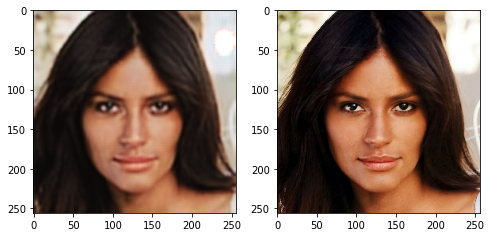

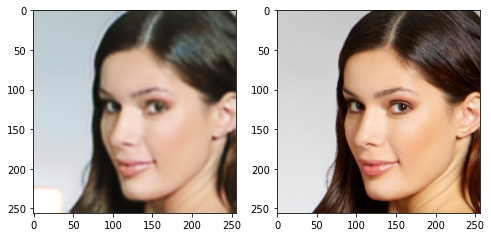

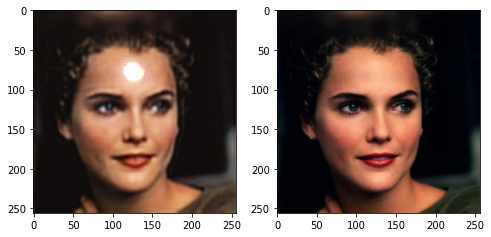

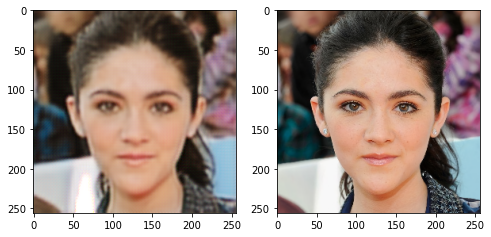

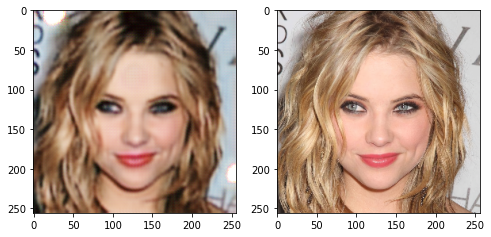

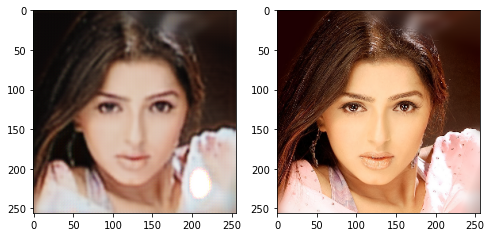

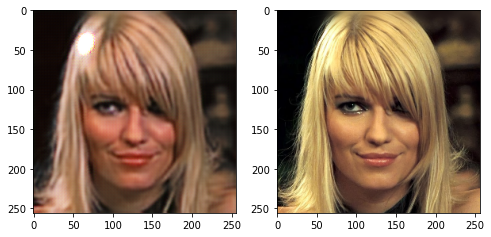

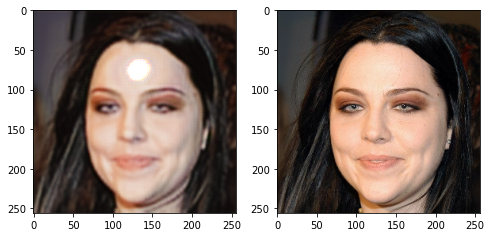

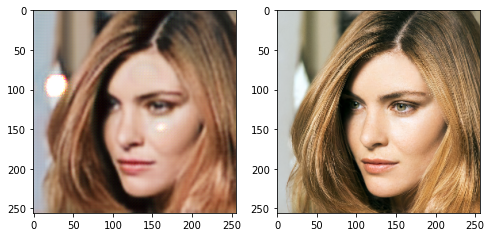

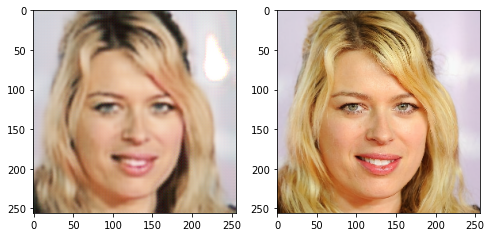

In [9]:
for i in range(len(predictions)):
    w = 10
    h = 10
    fig = plt.figure(figsize=(8, 8))
    columns = 2
    rows = 1
    fig.add_subplot(rows, columns, 1)
    plt.imshow(predictions[i])
    fig.add_subplot(rows, columns, 2)
    plt.imshow(test_x[i])
    plt.show()